<img src="../../../thu_sigs_logo.png" alt="清华深研院-横" style="zoom:50%;" />

In [2]:
#| default_exp big_data_analytics.matrix_decomposition

In [3]:
#|hide
# autoreload
%load_ext autoreload
%autoreload 2
%load_ext rich
from scholarly_infrastructure.logging.nucleus import logger, print
from thu_big_data_ml.help import plt

## 绪论


## 代码与文档格式说明

本文档使用Jupyter Notebook编写，所以同时包括了实验文档和实验代码。

本次实验项目采用了 Quarto + nbdev 的系统来发布Jupyter Notebook, 因而我们的实验文档导出为pdf和html格式可以进行阅读，而我们的代码也导出为python模块形式，可以作为代码库被其他项目使用。

我们这样做的好处是，避免单独管理一堆 .py 文件，防止代码冗余和同步混乱，py文件和pdf文件都是从.ipynb文件导出的，可以保证实验文档和代码的一致性。

::: {.callout-important}
可以通过以下命令安装我们实验的代码：

```shell
pip install git+https://github.com/Open-Book-Studio/THU-Coursework-Machine-Learning-for-Big-Data.git
```
我们的代码导出为了python模块形式，通过以下命令导入：
```python
from thu_big_data_ml.big_data_analytics.matrix_decomposition import *
```
:::

https://github.com/Open-Book-Studio/THU-Coursework-Machine-Learning-for-Big-Data.git 是我们本次大数据机器学习课程实验的代码仓库地址。

而这次作业中，我开发的我们课题组的基础依赖库[ScholarlyInfrastructure](https://github.com/THU-CVML/ScholarlyInfrastructure)也相应地进行了代码更新。这个库对标`fastcore`库，对AI科研经常会用到的一些基础性地、和Python语言的表达力有关的代码进行了整理，比如PyTorch模型检查、清晰的日志、实验参数管理、异常处理、argmax自动函数优化等。接下来我们也会用到这个项目中的一些代码来完成本次作业。
<!-- 这里我们用到了实验参数管理功能，把超参数表达为随机变量，随即使用元参数优化算法进行搜索。 -->

```shell
pip install git+https://github.com/THU-CVML/ScholarlyInfrastructure.git
```

```python
from scholarly_infrastructure import *
```

以上代码库开源在github，欢迎各位同学、老师们提出宝贵意见，或者加入我们的开发一起完善，构建更加优质的科研工具。

::: {.callout-important}
本文档具有一定的交互性，建议使用浏览器打开html文件，这样比pdf文件阅读体验更佳。

由于这次项目作业内容太多，为了便于管理，我们将项目文档和代码分为了不同几个部分。

:::

In [4]:
#| hide
import nbdev; nbdev.nbdev_export()

## 实验目的与项目要求

> 老师给我们的要求是
>
> 1. 实现基于用户的协同过滤算法，并在测试集上计算RMSE。
> 2. 使用梯度下降法实现矩阵分解，优化目标函数，并在测试集上评估效果，尝试不同的参数组合。
> 3. 比较协同过滤和矩阵分解的优缺点。


~~作为Top1大学的学生~~，我们不仅需要完成以上内容，还需要进行一些深入的思考和探索。

1. 算法优化：针对协同过滤的稀疏性问题，我们计划实现基于近邻选择的优化策略，如KNN-based CF，并尝试利用GPU加速相似度计算。

2. 超参数调优：在矩阵分解中，我们将系统地搜索隐空间维度k和正则化参数λ的最佳组合，使用网格搜索结合交叉验证来确定最优参数。

3. 自定义改进：尝试在矩阵分解中引入非线性变换或自定义正则化项，探索是否能进一步提高推荐精度。

4. 全面对比分析：除了RMSE，我们还将从时间复杂度、可解释性、冷启动问题等方面全面比较协同过滤和矩阵分解的优缺点，并通过可视化手段展示实验结果。

事不宜迟，我们开始动手吧！

## 1. 实验数据整理

> Netflix 在2006年举办了奖金高达100万美元的Netflix Prize竞赛，旨在改进其电影推荐算法。这一竞赛吸引了大量AI开发者投身于推荐系统相关研究，并开辟了推荐算法商业化的先河。
> Netflix电影评价数据集包含来自48万用户对1.7万部电影的评价数据，评价数超过100万条。

我们选择了老师提供的Netflix数据集版本（一个子集），并使用里面的全部一万多个用户和一万多个电影的全量矩阵进行实验。

### 数据集的自动下载

我们在linux服务器中运行代码，因此优雅的方式是直接在服务器上下载数据集，加快速度。首先我们需要确认数据文件夹在哪里，这个是gitignore的一个文件夹。

In [5]:
from thu_big_data_ml.help import data_path

In [6]:
download_path = data_path / "netflix"
download_path.mkdir(exist_ok=True, parents=True)
download_path

Path('/home/ye_canming/repos/assignments/THU-Coursework-Machine-Learning-for-Big-Data/data/netflix')

根据老师分享的清华网盘链接，我们写出如下代码：

In [7]:
urls = [
    "https://cloud.tsinghua.edu.cn/seafhttp/files/5f936b33-0b44-4878-8c3c-320ad1863c3b/movie_titles.txt", 
    "https://cloud.tsinghua.edu.cn/seafhttp/files/54d448d0-88c1-4a6d-b0bc-80f1992deeca/netflix_test.txt",
    "https://cloud.tsinghua.edu.cn/seafhttp/files/bfafbb0a-30fc-4215-aee2-4b73cc2d6855/netflix_train.txt",
    "https://cloud.tsinghua.edu.cn/seafhttp/files/a228e885-c624-4cde-8c28-b88b3846e405/users.txt",
]
# 自动提取文件名，得到 movie_titles.txt
# filenames = [url[(url.rfind("F")+1):url.rfind("&dl=1")] for url in urls]
filenames = [url.split("/")[-1] for url in urls]
filenames

['movie_titles.txt', 'netflix_test.txt', 'netflix_train.txt', 'users.txt']

```bash
pip install py3-wget
```

```python
import py3_wget
for url, file in zip(urls, filenames):
    
    py3_wget.download_file(
        url=url,
        output_path=(download_path/file).as_posix(),
    )
```

### 数据读取

In [8]:
import pandas as pd
import numpy as np

由于我们有很多耗时操作，所以我们需要使用`joblib`库来将已经进行过的操作缓存到硬盘上，以便下次直接从硬盘中读取。


In [9]:
from thu_big_data_ml.help import joblib_memory

In [10]:
pd.read_csv = pd.read_csv = joblib_memory.cache(pd.read_csv) # 尽管都是从磁盘读取，cache之前需要11s来读取 训练集， cache之后不需要解析csv的格式，所以快很多，0s左右就可以读取。

现在我们来读取四个csv表格

In [11]:
# 读取用户列表, 根据老师给的文档的信息，文件有 10000 行，每行一个整数，表示用户的 id，文件对应本次作业的所有用户。
users = pd.read_csv(download_path/'users.txt', header=None, names=['user_id'])
print(users.shape)
users.head()

Wed 2024-11-27 02:26:38.300427

INFO     (10000, 1)                                                                                   ]8;id=48310;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=271397;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

,user_id
0,305344
1,387418
2,2439493
3,1664010
4,2118461


In [12]:
# 读取训练集，文件包含 689 万条用户打分，每行为一条打分，对应的格式为：用户 id 电影 id 分数 打分日期
# 我们用英文来标注列的名字。
train_data = pd.read_csv(download_path/'netflix_train.txt', sep=' ', header=None, names=['user_id', 'movie_id', 'rating', 'date'])
print(train_data.shape)
train_data.head()

Wed 2024-11-27 02:26:53.481444

INFO     (6897746, 4)                                                                                 ]8;id=809682;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=328194;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

,user_id,movie_id,rating,date
0,305344,1,1,2004-02-08
1,305344,3,2,2003-03-23
2,305344,4,1,2003-12-13
3,305344,5,1,2004-12-15
4,305344,6,1,2003-09-23


In [13]:
# 读取测试集, 文件包含约 172 万条用户打分，格式与训练集相同。
test_data = pd.read_csv(download_path/'netflix_test.txt', sep=' ', header=None, names=['user_id', 'movie_id', 'rating', 'date'])
print(test_data.shape)
test_data.head()

Wed 2024-11-27 02:27:00.168681

INFO     (1719466, 4)                                                                                 ]8;id=943708;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=187459;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

,user_id,movie_id,rating,date
0,2123534,6134,4,2005-05-31
1,2123534,677,1,2005-06-06
2,2123534,3182,4,2005-06-06
3,2123534,7882,4,2005-06-27
4,2123534,6099,1,2005-05-31


In [14]:
# 读取电影名称,文件对应每部电影的年份和名称，格式为：电影 id, 年份, 名称, 各项之间用逗号分隔。
try:
    movies = pd.read_csv(download_path/'movie_titles.txt', sep=',', header=None, encoding='utf-8')
except Exception as e:
    print(f"Error: {e}")

________________________________________________________________________________
[Memory] Calling pandas.io.parsers.readers.read_csv...
read_csv(Path('/home/ye_canming/repos/assignments/THU-Coursework-Machine-Learning-for-Big-Data/data/netflix/movie_titles.txt'), sep=',', header=None, encoding='utf-8')


Wed 2024-11-27 02:27:06.575093

INFO     Error: Error tokenizing data. C error: Expected 3 fields in line 72, saw 4                   ]8;id=540945;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=637822;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\
                                                                                                                   

可以看到我们遇到了一个报错，72行的数据是这样的“72,1974,At Home Among Strangers, A Stranger Among His Own”
一个电影名自己包括分隔符","在里面，导致了pandas读取出错，
怎么解决这个问题呢？

我们可以指定 names ，或者改变 sep使用正则表达式，强制要求有三个字段。

In [15]:
try:
    movies = pd.read_csv(download_path / 'movie_titles.txt', sep=r'\s*,\s*', header=None, encoding='utf-8',
                        names=['movie_id', 'year', 'title'], engine='python')
except Exception as e:
    print(f"Error: {e}")

________________________________________________________________________________
[Memory] Calling pandas.io.parsers.readers.read_csv...
read_csv(Path('/home/ye_canming/repos/assignments/THU-Coursework-Machine-Learning-for-Big-Data/data/netflix/movie_titles.txt'), sep='\\s*,\\s*', header=None, encoding='utf-8', names=['movie_id', 'year', 'title'], engine='python')


Wed 2024-11-27 02:27:13.589576

INFO     Error: 'utf-8' codec can't decode byte 0xe9 in position 2872: invalid continuation byte      ]8;id=988366;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=819723;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

为了解决编码问题，我们使用 chardet 自动检测数据的 编码格式。
```bash
pip install chardet
```

In [16]:
import chardet

In [17]:
with open(download_path / 'movie_titles.txt', 'rb') as f:
    rawdata = f.read()
encoding = chardet.detect(rawdata)['encoding']
encoding

'ISO-8859-1'

In [18]:
try:
    movies = pd.read_csv(download_path / 'movie_titles.txt', sep=r'\s*,\s*', header=None, encoding=encoding, 
                        names=['movie_id', 'year', 'title'], engine='python')
except Exception as e:
    print(f"Error: {e}")

________________________________________________________________________________
[Memory] Calling pandas.io.parsers.readers.read_csv...
read_csv(Path('/home/ye_canming/repos/assignments/THU-Coursework-Machine-Learning-for-Big-Data/data/netflix/movie_titles.txt'), sep='\\s*,\\s*', header=None, encoding='ISO-8859-1', names=['movie_id', 'year', 'title'], engine='python')


Wed 2024-11-27 02:27:34.367837

INFO     Error: Expected 3 fields in line 72, saw 4. Error could possibly be due to quotes being      ]8;id=736658;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=860474;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\
         ignored when a multi-char delimiter is used.                                                              

看来就算指定了 names， pandas无法知道我们面对多个逗号的时候处理的逻辑，而sep使用了正则表达式加上两边空白符对于本例无效，因为我们的分隔符实际上是没有空格的逗号。实际上，我们的规则是第一次遇到的两个逗号算数，后面的逗号无效。

我们现在手动使用Python代码来处理这个复杂的逻辑，最后再转换为dataframe。

In [19]:
with open(download_path / 'movie_titles.txt', 'r', encoding=encoding) as file:
    lines = file.readlines()
lines[:3]

['1,2003,Dinosaur Planet\n', '2,2004,Isle of Man TT 2004 Review\n', '3,1997,Character\n']

In [20]:
movies = []
for i, line in enumerate(lines):
    # 去除最后一个 \n
    line = line.strip()
    if line=="": # 最后一行空行
        continue
    # 前两个逗号算数，第三个逗号无效
    splits = line.split(',', 2)
    # print(splits)
    try:
        row_data = [int(splits[0]), int(splits[1]), splits[2]]
    except Exception as e:
        print(e)
        print(line, splits)
        break
        # logger.exception(e)
    movies.append(row_data)


Wed 2024-11-27 02:27:57.906744

INFO     invalid literal for int() with base 10: 'NULL'                                               ]8;id=539663;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=933165;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

Wed 2024-11-27 02:27:57.925426

INFO     ('4388,NULL,Ancient Civilizations: Rome and Pompeii', ['4388', 'NULL', 'Ancient              ]8;id=676802;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=916550;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#55\55]8;;\
         Civilizations: Rome and Pompeii'])                                                                        

我们可以看到再次出现报错，有的电影缺失了year这个字段，并且是用"NULL"字符串表示的。我们可以把它当做None，让Pandas处理为NaN。

In [21]:
from scholarly_infrastructure import default_on_exception
default_on_exception?

Signature: default_on_exception(func, default_value=None, verbose=False)
Docstring: <no docstring>
File:      ~/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/nucleus.py
Type:      function

In [22]:
int_or_none = default_on_exception(lambda x: int(x), default_value=None)
movies = []
for i, line in enumerate(lines):
    # 去除最后一个 \n
    line = line.strip()
    if line=="": # 最后一行空行
        continue
    # 前两个逗号算数，第三个逗号无效
    splits = line.split(',', 2)
    row_data = [int_or_none(splits[0]), int_or_none(splits[1]), splits[2]]
    movies.append(row_data)

In [23]:
# 将列表转换为 DataFrame
movies = pd.DataFrame(movies, columns=['movie_id', 'year', 'title'])
print(movies.shape)
movies.head()

Wed 2024-11-27 02:28:34.328107

INFO     (17770, 3)                                                                                   ]8;id=525518;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=734265;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

,movie_id,year,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


### 数据预处理为评分矩阵X


In [24]:
from scipy.sparse import csr_matrix

`csr_matrix`是Compressed Sparse Row matrix，适合用于行操作比较多的场景。在这个推荐系统的问题中，用户是行，电影是列，每个元素是用户的评分。由于用户和电影的数量都很大，而且每个用户只评过很少的电影，所以这个矩阵会非常稀疏。用稀疏矩阵来表示可以节省内存和计算时间。

那么怎么从刚才的原始数据得到评分矩阵呢？首先，我先对用户ID和电影ID分别建立一个字典，这个字典把行的索引（比如0-9999这些用户）和"user_id"实际的值去做映射。我们必须做这一步，不然索引是不安全的。我们使用行列的索引而非原始的user_id来做后续的操作。

In [25]:
# 对用户ID进行排序，并映射到行索引
sorted_users = users.sort_values('user_id')
user_to_row = {user_id: idx for idx, user_id in enumerate(sorted_users['user_id'])}
# 对电影ID进行排序，并映射到列索引
sorted_movies = movies.sort_values('movie_id')
movie_to_col = {movie_id: idx for idx, movie_id in enumerate(sorted_movies['movie_id'])}

但是需要注意的是，data不一定用到了所有的user_id 和 movie_id, 所以实际上movie用到的只有老师说的"10000"多个，而不是 17770个。
<!-- 首先我们需要搞明白训练集和测试集的关系是什么，他们的用户都是哪些？是一样的用户ID吗？ -->

In [26]:
train_data['user_id'].nunique(), train_data['movie_id'].nunique(), test_data['user_id'].nunique(), test_data['movie_id'].nunique()

(10000, 10000, 10000, 9983)

首先我们还需要搞明白训练集和测试集的关系是什么，他们的用户和电影是否重叠呢？

In [27]:
# 集合取交集
len(set(train_data['user_id'].unique()) & set(test_data['user_id'].unique())), len(set(train_data['movie_id'].unique()) & set(test_data['movie_id'].unique()))

(10000, 9983)

::: {.callout-note}
一开始我以为，测试集和训练集的划分是根据不同的用户来操作的，我们需要用已知用户的评分去预测未知用户的评分，现在看来并不是这样的，一个用户实际上在训练集和测试集上都有出现，但是是不同的评分数据。我们接下来推荐系统中实际上是通过其他用户在训练集的评分来补全我们用户的评分，然后再用测试集已知的我们这个用户的评分来计算损失。
:::

我们再取并集来看，可以看出不管是训练集还是测试集，一共出现的都只有10000个电影和10000个用户。

In [28]:
# 集合取并集
len(set(train_data['user_id'].unique()) | set(test_data['user_id'].unique())), len(set(train_data['movie_id'].unique()) | set(test_data['movie_id'].unique()))

(10000, 10000)

为了让矩阵是$10000\times 10000$，而不是$10000\times 17770$，我们的索引需要压缩一下。

In [29]:
movies_set = set(train_data['movie_id'].unique()) | set(test_data['movie_id'].unique())
movie_to_col = {movie_id: idx for idx, movie_id in enumerate(movies_set)}

现在我们可以安全地从 train_data 和 tets_data 得到 $X_{train}, X_{test}$ 了，这个矩阵在《深度学习推荐系统》一书中又称作“共现矩阵”。

在scipy里，`csr_matrix`的构造函数可以接受三个参数： values, (rows, cols)，以及形状。 比如 values可以是 [10, 8], rows=[0, 1], cols=[3, 2], 这就表示在 (0, 3)和 (1, 2)两个坐标上矩阵的值是 10 和 8， 其他位置都是0（表示评分未知）。

这样我们就成功规避了老师提到的“计算机计算能力”不足无法处理矩阵的问题。
当然这里只是解决了存储问题，后续这个矩阵怎么去做进一步运算是值得思考的。

In [30]:
#| exports
# @joblib_memory.cache # data 哈希本身需要很大的开销，不宜 cache
def get_rating_matrix(data:pd.DataFrame)-> csr_matrix:
    rows = data['user_id'].map(user_to_row)
    cols = data['movie_id'].map(movie_to_col)
    values = data['rating']
    
    return csr_matrix((values, (rows, cols)), shape=(len(user_to_row), len(movie_to_col)))

In [31]:
X_train = get_rating_matrix(train_data)
X_test = get_rating_matrix(test_data)
X_train.shape, X_test.shape, type(X_train), X_train.dtype

((10000, 10000), (10000, 10000), <class 'scipy.sparse._csr.csr_matrix'>, dtype('int64'))

如果有些操作不被稀疏矩阵支持，我们可能还是需要稠密矩阵，我们把稠密矩阵也给出。

In [32]:
X_train_dense:np.array = X_train.toarray() # todense也可以
X_test_dense:np.array = X_test.toarray() # todense也可以
X_train_dense.shape, X_test_dense.shape, type(X_train_dense), X_train_dense.dtype

((10000, 10000), (10000, 10000), <class 'numpy.ndarray'>, dtype('int64'))

## 2. 基于用户的协同过滤实现

协同过滤思路很简单，“当需要判断用户 i 是否喜欢电影 j，只要看与 i 相似的用户，看他们是否喜欢电影 j，并根据相似度对他们的打分进行加权平均”，这里需要注意几个关键的点：
1. 判断用户i和用户j的相似性，是通过训练集i和j的相似性，而不是通过测试集用户i和用户j的相似性，也不是通过测试集i和训练集j的相似性，因为测试集本质上不是矩阵，而是单个评分，每次测试的时候我们知道的只有 user_id和movie_id，不能利用测试集的其他信息来判断相似性。
2. 判断用户i是否喜欢电影j，用户i自身和自己很相似，但是因为缺失了数据所以填写了0，万万不可以用矩阵中缺省值“0”加入评分的平均计算，所以寻找“与i相似的用户”时，需要排除用户i自己。


由于协同过滤有很多个不同的版本，而项目文档给出的公式缺乏对我上面说到的几个问题的严格定义，因此我们参考[《深度学习推荐系统》一书中的定义](https://yd.qq.com/web/reader/b7732f20813ab7c33g015deakaab325601eaab3238922e53)来实现代码。
提出协同过滤方法的论文是 《Amazon.com Recommenders Item-to-Item Collaborative Filtering》。

此外，协同过滤和机器学习方法有一定的关联，
- 协同过滤和使用cos相似度的weighted的K近邻（sklearn中的`KNeighborsRegressor(weights='distance', metric='cosine')`）比较相似，区别KNN一般预测一个值或者类别，这里预测整个一行。以及刚才我们提到的第2点，协同过滤不能使用用户自己。
- 计算一个矩阵每一行之间的相似度，把相似度矩阵存下来，也叫做Kernel Method，存下来的矩阵叫做Gram矩阵。

由于K近邻代码上和协同过滤还是有所区别，我们这里不使用K近邻实现推荐系统。

### 用户相似度计算

我们首先计算每个用户互相之间的相似度。

In [69]:
# 尝试在GPU上面算，期待会快一些
import torch
X_train_torch = torch.from_numpy(X_train_dense).float()
X_train_torch = X_train_torch.to("cuda")
try:
    cosine_sim = torch.nn.functional.cosine_similarity(X_train_torch[:, None], X_train_torch[None, :], dim=2)
except Exception as e:
    print(e)

Wed 2024-11-27 03:01:47.187771

INFO     CUDA out of memory. Tried to allocate 3725.29 GiB. GPU 0 has a total capacity of 23.69 GiB   ]8;id=394416;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=678646;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\
         of which 551.31 MiB is free. Process 1612869 has 1.91 GiB memory in use. Process 1631877 has              
         1.66 GiB memory in use. Including non-PyTorch memory, this process has 19.56 GiB memory in                
         use. Of the allocated memory 1.49 GiB is allocated by PyTorch, and 0 bytes is reserved by                 
         PyTorch but unallocated. If reserved but unallocated memory is large try setting                          
         PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation               
         for Memory Management                                                                                     
         (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)                                   

可惜PyTorch似乎不支持稀疏矩阵，我们暂时无法通过PyTorch在CUDA上面完成余弦相似度的计算。

我们还是使用CPU来做。根据sklearn的文档

> X : {array-like, sparse matrix} of shape (n_samples_X, n_features)
>    Input data.

sklearn支持通过稀疏的方式，针对稀疏矩阵进行优化的前提下，来计算相似度，速度应该是合理的。

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

In [35]:
@joblib_memory.cache
def get_similarities():
    simularities = cosine_similarity(X_train)
    return simularities

In [36]:
cosine_sim = get_similarities()

我们经过 352.9s, 5.9min 的时间，成功计算出 10000 x 10000 的余弦相似度矩阵。
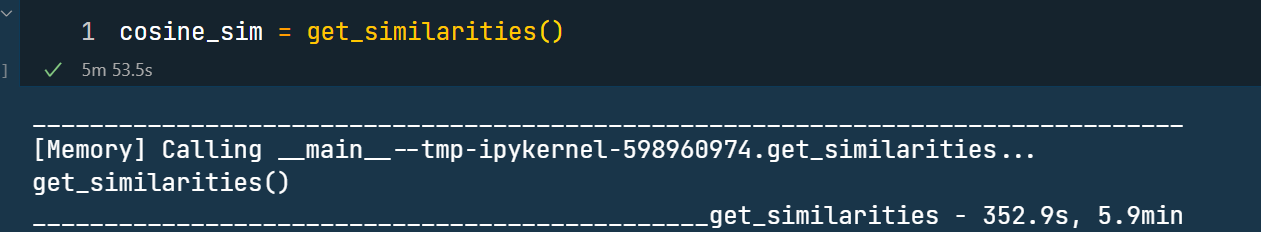

由于我们使用了 `joblib`缓存结果, 第二次加载这个矩阵只需要 3.3s 。

In [37]:
cosine_sim.shape, type(cosine_sim), cosine_sim.dtype

((10000, 10000), <class 'numpy.ndarray'>, dtype('float64'))

In [38]:
cosine_sim[:5, :5]


array([[1.        , 0.29042362, 0.27409518, 0.29692921, 0.34769348],
       [0.29042362, 1.        , 0.29676954, 0.2805517 , 0.23722667],
       [0.27409518, 0.29676954, 1.        , 0.39591191, 0.32875298],
       [0.29692921, 0.2805517 , 0.39591191, 1.        , 0.30646964],
       [0.34769348, 0.23722667, 0.32875298, 0.30646964, 1.        ]])

值得注意的是，`cosine_similarity`和`cosine_distances`有所不同，这两个加在一起是1，不要搞混了。

### “推理”协同过滤模型

按照协同过滤算法本身来说，现在我们本来只需要对测试集的每一个评分开始预测就行了，对测试集有评分的每一个用户和每一个电影，按照公式去计算训练集中相似的用户的评分的加权平均数就可以了。

但是我们可以把思路理地更清晰一些，实际上训练集确定的情况下，整个训练集的矩阵每一行是什么情况都是可以计算的，未来测试集只需要查询对应的结果即可，我们按照机器学习的术语，把这个过程称为“推理”（而刚才计算相似度矩阵的过程可以称为“训练”），得到的模型是新的 10000 x 10000的矩阵，每一行的评分是通过原始矩阵其他行的打分加权平均计算得到的。

如此一来，我们的操作是向量化的。

首先，根据我上面提到的“第二点”，我们需要排除用户自身和自身的相似度，不能用用户自身的评分来预测。实际上，更加合理的做法是计算平均数的时候排除评分为0的情况。

我们可以使用 np.nanmean() 来在忽略缺失值的情况下计算平均值。


In [39]:
example_array = np.array([np.nan, np.nan, 1])
np.nanmean(example_array) # 正确的结果是 1.0，错误的结果是 1/3

1.0

In [40]:
# 如果是加权平均数，也是同理
example_weights = [1, 2, 3]
mask = np.isnan(example_array)
weights = np.where(mask, np.nan, example_weights)
weighted_sum = np.nansum(example_array * weights)
weight_sum = np.nansum(weights)
weighted_mean = weighted_sum / weight_sum
weighted_mean # 应当仍是1 , 而不是 0.5

1.0

理论清晰了，刚才我们已经知道怎么对向量做操作，现在我们可以编写代码来排除没有评分的列的情况下求加权平均数，对整个矩阵去做操作。

In [41]:
X_train_dense = X_train_dense.astype(np.float64)

In [42]:
from copy import deepcopy
from tqdm import tqdm

In [43]:
# 评分范围是 1-5, 所以0就是缺失值，刚才稀疏矩阵的默认设为了0，我们需要nan
X_train_dense_nan = deepcopy(X_train_dense)
X_train_dense_nan[X_train_dense_nan==0] = np.nan
X_train_dense_nan[0]

array([nan, nan, nan, ..., nan, nan, nan])

In [44]:
np.ones((2, 3)).sum(axis=0)

array([2., 2., 2.])

In [45]:
#| exports

def compute_weighted_sum_on_matrix(cosine_sim, X_train_dense_nan):
# 创建一个与 X_train_dense 相同大小的矩阵，用于存储加权平均数
    X_train_weighted = np.zeros_like(X_train_dense_nan)

    # 遍历 X_train_dense 的每一行
    for i in tqdm(range(X_train_dense_nan.shape[0])):
        # 获取第 i 行的权重
        weights = cosine_sim[i, :]
        
        # 复制这个权重到整个矩阵的维度，方便后面掩码操作
        weights = np.repeat(weights, X_train_dense_nan.shape[1]).reshape(X_train_dense_nan.shape[0], X_train_dense_nan.shape[1])
        
        
        # 创建一个掩码，是 nan的就是True
        mask = np.isnan(X_train_dense_nan)
        
        
        # 将权重中的对应位置设置为 np.nan
        weights = np.where(mask, np.nan, weights)
        
        # 计算加权平均数，忽略 np.nan 值
        X_train_weighted[i, :] = np.nansum(X_train_dense_nan * weights, axis=0) / np.nansum(weights, axis=0)

    # X_train_weighted 现在是一个 mxn 的矩阵，其中每一行是忽略 np.nan 的加权平均数
    return X_train_weighted

@joblib_memory.cache
def get_X_train_weighted():
    return compute_weighted_sum_on_matrix(cosine_sim, X_train_dense_nan)

In [46]:
# X_train_weighted = get_X_train_weighted()

可以看到速度非常慢，不可接受（4分钟连第一个计算也没有完成），我们需要进行一些优化。
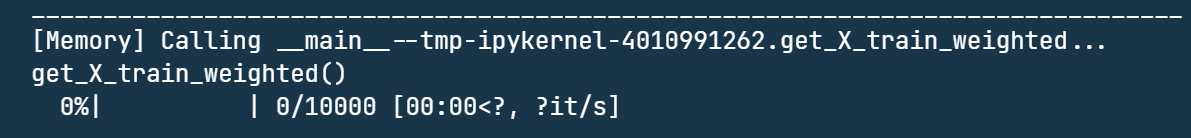

#### 速度优化——矩阵乘法

如果我们不考虑加权平均数需要忽略没有评分的其他用户这一问题，直接把0当做是有效的评分，并且基于相似度直接计算加权平均数，那么我们马上就发现其实矩阵乘法
cosine_sim @ X_train_dense 是有意义的，这就等价于每一行的 cosine_sim 线性组合 X_train_densede 所有行向量。这个离加权平均数只差了一个归一化的步骤，新的矩阵的每一行需要 除以 cosine_sim 那一行的和。

In [47]:
weight_sum = cosine_sim.sum(axis=1) # 每一行的和
weight_sum.shape

(10000,)

In [48]:
X_train_pred_wrong = (cosine_sim @ X_train_dense) / weight_sum[:, np.newaxis] # 升维变成一列向量，这样才能每一行去除这个值而不是每一列去除。
X_train_pred_wrong.shape

(10000, 10000)

In [49]:
X_train_pred_wrong[0]


array([0.0410934 , 0.00174947, 0.10677668, ..., 0.00775722, 0.01182744,
       0.02292204])

当然上面得到的结果是错误的，我们看到里面的值都是“0.0410934”之类的，明显小于1，不可能是实际的评分取值，这就是因为没有考虑到刚才我们说的排除没有和商品交互的用户提供的0评分的问题。

我们仔细观察上面的公式，可以发现 cosine_sim @ X_train_dense 其实计算的是正确的，因为评分为0的时候自然不会算进去，问题出在`/ weight_sum[:, np.newaxis]` 这一步把评分为0的用户也算了进去。

因此，正确的解决办法是，对每一个用户和每一个物品，都有不同的 weight_sum。
给定一个用户的时候，确定了和其他用户的相似性，但是不同物品有不同的nan mask，从而weight的加和有所不同。

我们经过一段时间的思考，可以注意到，这其实也是可以通过一个矩阵乘法来解决的。首先我们定义`mask`矩阵，如果是0（缺失评分）mask就是1，否则就是0。我们注意到`(1-mask)`矩阵，如果当做是一行列向量，那么每一个列向量就表示了物品对用户的选择，也就是这个物品有哪些用户是有评分的。使用这个列向量去对`cosine_sim`进行线性组合，其含义就是在进行一个选择性求和，只有非nan的地方才会相加。

In [50]:
mask = np.isnan(X_train_dense_nan)
weight_sum_correct = cosine_sim@(1-mask)
weight_sum_correct.shape

(10000, 10000)

In [51]:
X_train_pred = (cosine_sim @ X_train_dense) / weight_sum_correct
X_train_pred.shape

(10000, 10000)

最终我们的公式非常的简洁 `(cosine_sim @ X_train_dense) / (cosine_sim @ (X_train_dense!=0))`, 其中 @ 表示矩阵乘法， / 表示逐元素相除。

In [52]:
X_train_pred[0]


array([3.57833886, 1.76862034, 3.38810491, ..., 2.66767709, 1.94945024,
       2.63015681])

可以看到这一次我们得到的数值是正确的，是1-5的评分能得到的平均数。
网络上很多协同过滤的博客参差不齐，都没有提到这个公式，都是用for去写的，而《深度学习推荐系统》一书也没有涉及到这个细节。这里我们自己通过数学推导，终于得到了正确而高效的计算公式。

刚才我们是用稠密矩阵来实现对应的公式的，由于矩阵乘法已经被numpy库深度优化，所以我们的计算很高效。下面我们尝试稀疏矩阵实现同样的计算。
```python
cosine_sim_sparse = csr_matrix(cosine_sim)
not_zero_rating = csr_matrix(1-mask) # 实际上这个很稀疏，很多元素都是0
X_train_pred_sparse = (cosine_sim_sparse @ X_train) / (cosine_sim_sparse @ not_zero_rating)
X_train_pred_sparse.shape
np.allclose(X_train_pred, X_train_pred_sparse.toarray())
```

可以发现稀疏矩阵的速度在这个数据规模上和这个问题上，比稠密矩阵的还要慢不少，无法在合理的时间内完成。
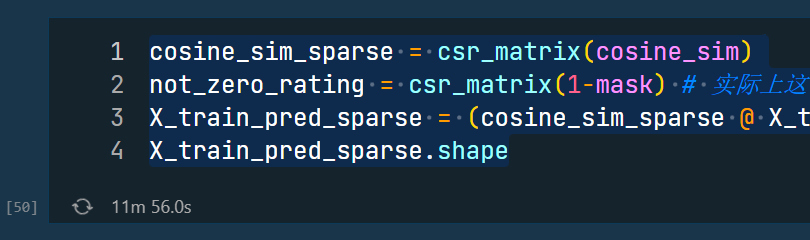

这可能是因为我们得到的最终结果是稠密的，经过矩阵乘法之后稀疏矩阵就不再稀疏，因而算法并不高效，需要算出10000*10000个点，还不如稠密矩阵表示。

### 评价协同过滤模型

现在我们有了 X_train_pred, 包括了对所有用户在所有物品上的评分，接下来只需要与 X_test 对比就可以了。

但是需要注意的是，X_test 并没有包含所有用户在所有物品上的评分，如果直接对这两个矩阵展开为向量去做RMSE，得到的结果当然是错误的。因为这样错误地把0评分和预测评分去做比较。

我们可以for遍历所有的测试数据，然后去查询 X_train_pred 中对应的评分，然后再去计算指标。我们也可以对矩阵去进行操作。

In [ ]:
test_mask = (X_test!=0)
masked_X_train_pred = test_mask * X_train_pred
n = test_mask.sum()
rmse = np.sqrt(((X_test-masked_X_train_pred)**2).sum() / n)
rmse

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 test_mask = (X_test!=0)                                                                      │
│ ❱ 2 masked_X_train_pred = test_mask * X_train_pred                                               │
│   3 n = test_mask.sum()                                                                          │
│   4 rmse = np.sqrt(((X_test-masked_X_train_pred)**2).sum() / n)                                  │
│   5 rmse                                                                                         │
│                                                                                                  │
│ /home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/scipy/spar │
│ se/_matrix.py:48 in __mul__                                                                      │
│                                                                                                  │
│    45 │                                                                                          │
│    46 │   # Restore matrix multiplication                                                        │
│    47 │   def __mul__(self, other):                                                              │
│ ❱  48 │   │   return self._mul_dispatch(other)                                                   │
│    49 │                                                                                          │
│    50 │   def __rmul__(self, other):                                                             │
│    51 │   │   return self._rmul_dispatch(other)                                                  │
│                                                                                                  │
│ /home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/scipy/spar │
│ se/_base.py:526 in _mul_dispatch                                                                 │
│                                                                                                  │
│    523 │   │   │   elif other.shape == (N, 1):                                                   │
│    524 │   │   │   │   return self._mul_vector(other.ravel()).reshape(M, 1)                      │
│    525 │   │   │   elif other.ndim == 2 and other.shape[0] == N:                                 │
│ ❱  526 │   │   │   │   return self._mul_multivector(other)                                       │
│    527 │   │                                                                                     │
│    528 │   │   if isscalarlike(other):                                                           │
│    529 │   │   │   # scalar value                                                                │
│                                                                                                  │
│ /home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/scipy/spar │
│ se/_compressed.py:501 in _mul_multivector                                                        │
│                                                                                                  │
│    498 │   │                                                                                     │
│    499 │   │   # csr_matvecs or csc_matvecs                                                      │
│    500 │   │   fn = getattr(_sparsetools, self.format + '_matvecs')                              │
│ ❱  501 │   │   fn(M, N, n_vecs, self.indptr, self.indices, self.data,                            │
│    502 │   │      other.ravel(), result.ravel())                                                 │
│    503 │   │                                               

## 3. 基于梯度下降的矩阵分解算法实现

我们首先复习一下吴老师课程讲解的内容。

老师课上强调，矩阵分解可以把PCA、SVD、LDA三个重要的方法统一起来。

我们可以使用 PyTorch 来实现梯度下降矩阵分解，但是这里我们同时也尝试一下 jax 来实现。因为 jax 是 谷歌提出的新一代框架，结合了 NumPy 的接口和自动微分功能，以及强大的编译优化，据一些研究指出具有较好的性能。
```python
pip install -U "jax[cuda12]"
```

### 模型定义

首先我们需要定义我们的模型，具体来说需要定义模型的参数 U和V。U和V建模了评分矩阵。

In [70]:
# 定义分解矩阵的大小
k = 50  # 隐向量维度
m, n = X_train_torch.shape

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# 初始化矩阵
# PyTorch写法
U = torch.randn(m, k, requires_grad=True)
V = torch.randn(n, k, requires_grad=True)

In [61]:
# 再尝试一下jax
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import jax.random as jrandom

In [ ]:
# jax不需要 requires_grad 因为求导的逻辑不一样，jax待会会直接定义导函数。
key = jrandom.PRNGKey(42)
jU = jrandom.normal(key, (m, k))
jV = jrandom.normal(key, (n, k))

为了让代码规范一些，我们把参数写为 module 形式。

In [ ]:
#| export
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, k):
        super().__init__()
        self.U = nn.Parameter(torch.randn(n_users, k))
        self.V = nn.Parameter(torch.randn(n_items, k))
    
    def forward(self):
        return torch.matmul(self.U, self.V.t())

### 损失函数定义

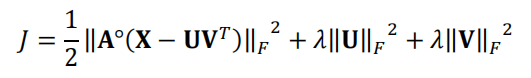

注意在 PyTorch 的设计哲学中，正则化项是通过优化器`weight_decay`选项来实现的，而不是在损失函数中计算。
这是因为损失函数通常输入是 (y_pred, y_true) 的形式，不包含模型参数，而优化器对模型的参数有完全的访问权。

所以我们下面损失函数暂时忽略 $\lambda$ ，稍后会加入回来。

In [79]:
#| export
# 定义PyTorch的损失函数
def masked_mse_loss(reconstructed:torch.Tensor, matrix:torch.Tensor)->torch.Tensor:
    observed_indices = torch.where(matrix != 0) # A 矩阵，表示哪里是有评分的，只在有评分的地方算loss。
    return 0.5*torch.mean((reconstructed[observed_indices] - matrix[observed_indices])**2)


### 梯度下降训练分解矩阵U和V

In [86]:
lmd = 1e-3
# lr = 3e-4
lr = 1e-2

In [87]:
# 优化循环
model = MatrixFactorization(m, n, k).to('cuda:2')
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=lmd)
losses = []
bar = tqdm(range(100))
for epoch in bar:
    optimizer.zero_grad()
    pred_matrix = model()
    loss = masked_mse_loss(pred_matrix, X_train_torch.to('cuda:2'))
    loss.backward()
    losses.append(loss.item())
    bar.set_postfix(loss=loss.item())
    optimizer.step()

100%|██████████| 100/100 [00:19<00:00,  5.21it/s, loss=2.82]


In [88]:
# plotly 画出 losses
import plotly.graph_objects as go
# 创建一个折线图
fig = go.Figure(data=go.Scatter(
    x=list(range(len(losses))),  # 横坐标，这里假设是 losses 数组的索引
    y=losses,             # 纵坐标，即 losses 数组的值
    mode='lines+markers', # 模式，lines+markers 表示线条和点
    name='Loss'
))

# 更新图表的布局
fig.update_layout(
    title='Loss Over Time',  # 图表标题
    xaxis_title='Epoch',    # x轴标题
    yaxis_title='Loss',     # y轴标题
    plot_bgcolor='white'   # 背景颜色
)

# 显示图表
fig.show()

In [53]:
#| hide
import nbdev; nbdev.nbdev_export()